### The function to apply a circular neighborhood filter to MPAS unstructured mesh under github repository uxarray branch [ahijevyc:ahijevyc/neighborhood_filter](ahijevyc/neighborhood_filter).

In [1]:
import logging
import os
import warnings
from functools import partial
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
import geoviews.feature as gf
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import pandas as pd
import uxarray
import xarray
from sklearn.neighbors import BallTree as SKBallTree
from tqdm import tqdm
from util import dBZfunc, dec_ax, xtime

import G211  # 80-km CONUS grid

try:  # Avoid ValueError when assigning cmap again
    cmap = cmaps.WhiteBlueGreenYellowRed
except ValueError:
    pass
%matplotlib inline

In [3]:
uxarray.__version__

'2025.6.1.dev21+g6733d30b.d20250805'

## Read MPAS into UxDataset

* subset with bounding box

In [80]:
grid_path = "/glade/campaign/mmm/wmr/weiwang/cps/irma3/2020/tk707_conus/init.nc"
uxds = uxarray.open_mfdataset(
    grid_path,
    Path("/glade/campaign/mmm/wmr/weiwang/cps/irma3/mp6/tk707").glob("diag*.nc"),
    preprocess=xtime,
)

lon_bounds = (-74, -64)
lat_bounds = (18, 24)
uxda = uxds["refl10cm_max"].isel(valid_time=12).subset.bounding_box(lon_bounds, lat_bounds).load()

In [81]:
uxda.plot(cmap=cmap) * gf.coastline(projection=ccrs.PlateCarree())

:Overlay
   .Image.I     :Image   [x,y]   (x_y refl10cm_max)
   .Coastline.I :Feature   [Longitude,Latitude]

### Apply circular neighborhood filter function `func` with radius `r` (in degrees)

* can be simple function like max, min, np.mean
* or the function could require an argument, like np.percentile(quantile=q)

In [4]:
func = partial(np.percentile, q=90)
r = 0.25
uxda.neighborhood_filter(func=func, r=r).plot(
    cmap=cmap, dynamic=True
) * gf.coastline(projection=ccrs.PlateCarree())

AttributeError: 'UxDataArray' object has no attribute 'neighborhood_filter'

### Create SCRIP latlon grid with NCO tool `ncregrid`

* uxarray can read SCRIP

In [69]:
import os
import subprocess

# --- Step 1: Get the Lmod program path from the environment variable ---
path_to_cmd = os.environ.get('LMOD_CMD')

# Check if the environment variable exists
if not path_to_cmd:
    raise RuntimeError(
        "The LMOD_CMD environment variable is not set in your Jupyter kernel. "
        "The kernel may need to be restarted or launched in a different way."
    )

# --- Step 2: Define the module you want to load ---
module_to_load = "nco/5.3.1"

# --- Step 3: Build and execute the command using the correct path ---
command = f'{path_to_cmd} python load {module_to_load}'

print(f"Executing command: '{command}'")
proc = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Check for errors
if proc.returncode != 0:
    print("\n--- ERROR ---")
    print("Error loading module:")
    print(proc.stderr)
else:
    # Execute the Python code to modify the environment
    exec(proc.stdout)
    print(f"\nSuccessfully loaded module: {module_to_load}")

# --- Step 4: Verify (Optional) ---
print("\nVerifying with 'which ncks':")
os.system("which ncks")

Executing command: '/glade/u/apps/casper/24.12/spack/opt/spack/lmod/8.7.37/gcc/12.4.0/diu3/lmod/lmod/libexec/lmod python load nco/5.3.1'

Successfully loaded module: nco/5.3.1

Verifying with 'which ncks':
/glade/u/apps/casper/24.12/spack/opt/spack/nco/5.3.1/gcc/12.4.0/xj2m/bin/ncks


0

In [77]:
import subprocess

dlat = dlon = 1
# lon_typ=grn_wst means Greenwich is west edge of cell instead of center
subprocess.run(
    f"ncremap -g grd.nc -G latlon={180/dlat:.0f},{360/dlon:.0f}#lon_typ=grn_wst".split()
)

# make sure 24N is included.
lat_bounds_plus = (lat_bounds[0], lat_bounds[1] + 0.001)
latlonGrid = uxarray.open_grid("grd.nc").subset.bounding_box(lon_bounds, lat_bounds)
latlonGrid

ncremap: WARNING grd.nc already exists and will be overwritten by newly created grid


<uxarray.Grid>
Original Grid Type: Scrip
Grid Dimensions:
  * n_node: 66
  * n_face: 50
  * n_max_face_nodes: 4
Grid Coordinates (Spherical):
  * node_lon: (66,)
  * node_lat: (66,)
  * face_lon: (50,)
  * face_lat: (50,)
Grid Coordinates (Cartesian):
  * node_x: (66,)
  * node_y: (66,)
  * node_z: (66,)
Grid Connectivity Variables:
  * face_node_connectivity: (50, 4)
Grid Descriptor Variables:
  * n_nodes_per_face: (50,)

### Apply neighborhood filter

* remap to latlon grid

In [78]:
#var_ll = uxda.neighborhood_filter(func=func, r=0.25).remap.nearest_neighbor(latlonGrid)
var_ll = uxda.remap.nearest_neighbor(latlonGrid)
data_plot = var_ll.plot(cmap=cmap, dynamic=True) * gf.coastline(projection=ccrs.PlateCarree())
grid_plot = var_ll.uxgrid.plot()
data_plot * grid_plot

:DynamicMap   []
   :Overlay
      .Image.I     :Image   [x,y]   (x_y TS)
      .Coastline.I :Feature   [Longitude,Latitude]
      .Path.I      :Path   [Longitude,Latitude]

In [79]:
data_file = "var_ll.nc"
if os.path.exists(data_file):
    os.remove(data_file)
var_ll.to_netcdf(data_file)
grid_file = "uxgrid.nc"
if os.path.exists(grid_file):
    os.remove(grid_file)
var_ll.uxgrid.to_xarray().to_netcdf(grid_file)
my_var = uxarray.open_dataset(grid_file, data_file)['TS']

my_var.plot(cmap=cmap)

/glade/work/ahijevyc/conda-envs/uxarray/lib/python3.12/site-packages/xarray/namedarray/core.py:503: UserWarning: Duplicate dimension names present: dimensions {'two'} appear more than once in dims=('n_face', 'two', 'two'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  self._dims = self._parse_dimensions(value)
/glade/work/ahijevyc/conda-envs/uxarray/lib/python3.12/site-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'two'} appear more than once in dims=('n_face', 'two', 'two'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to bec

:Image   [x,y]   (x_y TS)

### Reshape 1-dimensional UxDataArray to 2-d lat-lon DataArray

* save to netCDF
* UxArray.Dataset.to_netcdf does not make a useful file on its own. it is 1-d and not readable by uxarray.open_uxdataset
* But if you save the uxgrid also, you can read them into a UxArray.Dataset

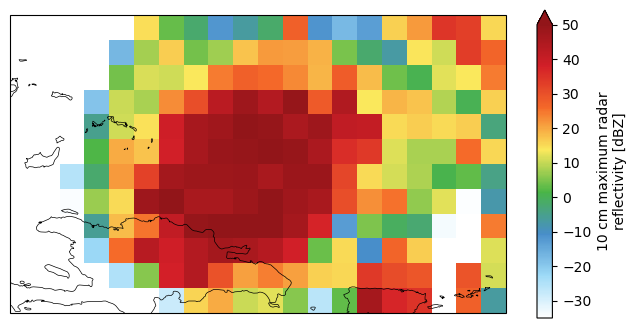

In [55]:
lats = np.arange(*lat_bounds, dlat) + dlat / 2
lons = np.arange(*lon_bounds, dlon) + dlon / 2
da = xarray.DataArray(
    var_ll.values.reshape((lats.size, lons.size)),
    coords=dict(lat=lats, lon=lons),
    name=uxda.name,
    attrs=uxda.attrs,
)

fig, ax = plt.subplots(
    figsize=(8, 4),
    subplot_kw=dict(projection=ccrs.PlateCarree()),
)
da.plot(ax=ax, cmap=cmap, vmin=-35, vmax=50)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

# save to netCDF
ofile = "latlon.nc"
da.to_netcdf(ofile)

In [ ]:
idir = Path("/glade/campaign/mmm/parc/sobash/MPAS_regional_cheyenne/2023032500")
grid_path = idir / "conus.init.nc"
uxarray.open_dataset(
    grid_path,
    idir / "diag.2023-03-25_17.00.00.nc",
)["refl10cm_max"].isel(
    Time=0
).plot.rasterize(cmap=cmap) * gf.states(projection=ccrs.PlateCarree())

## HWT MPAS

* Trim to lat/lon box

In [66]:
idate = pd.to_datetime("20230429T00")
base_path = (
    Path("/glade/campaign/mmm/parc/schwartz/HWT2023/mpas")
    / idate.strftime("%Y%m%d%H")
    / "post/mem_5"
)
grid_path = "/glade/campaign/mmm/parc/schwartz/MPAS/15-3km_mesh/mpas_init/static.nc"
# Paths to Data Variable files
var_names = [
    d.strftime("diag.%Y-%m-%d_%H.%M.%S.nc")
    for d in pd.date_range(
        start=idate + pd.Timedelta(hours=3),
        end=idate + pd.Timedelta(hours=9),
        freq="3h",
    )
]
data_paths = [base_path / name for name in var_names]

uxds = uxarray.open_mfdataset(
    grid_path, data_paths, concat_dim="Time", combine="nested", use_dual=False
)

lat0, lat1 = 41, 42.5
lon0, lon1 = -75, -70

lon_bounds = (lon0, lon1)
lat_bounds = (lat0, lat1)
da = uxds["refl10cm_max"].isel(Time=0).subset.bounding_box(lon_bounds, lat_bounds)

figw = 12

triang = tri.Triangulation(da.uxgrid.face_lon, da.uxgrid.face_lat)

projection = ccrs.LambertConformal(central_longitude=-82)
if lon1 - lon0 > 15:
    projection = ccrs.PlateCarree()

norm = mpl.colors.Normalize(vmin=0, vmax=50)

### Upscale to NCEP grid 211 (80 km) with SKBallTree
<li>rectangular neighborhood</li>
<li>circular region of influence</li>

100%|██████████| 6045/6045 [00:00<00:00, 7595.45it/s] 


Text(0.5, 0.98, '8224 cells')

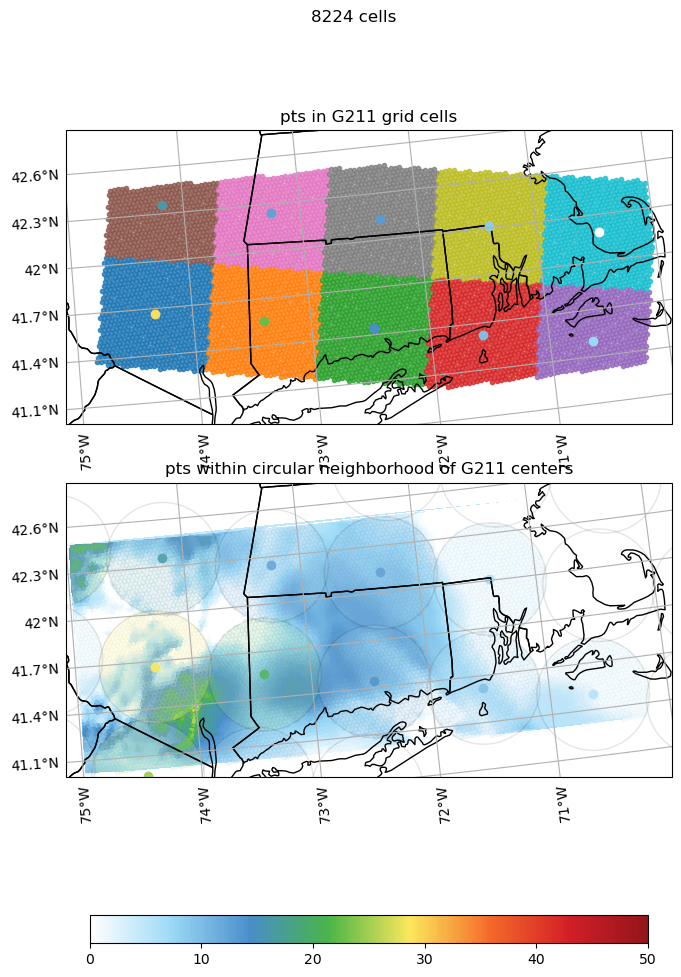

In [67]:
warnings.filterwarnings("ignore", message="Approximating coordinate system")
latlon = np.deg2rad(np.c_[da.uxgrid.face_lat, da.uxgrid.face_lon])
X = np.deg2rad(np.c_[G211.lat.ravel(), G211.lon.ravel()])

# For each G211 cell, find indices of MPAS cells associated with it.
# Each element in the list will be a list of MPAS cells in the neighborhood and shape of a G211 cell.
idxs = SKBallTree(X, metric="haversine").query(latlon, return_distance=False)

fig, axes = plt.subplots(nrows=2, figsize=(figw, 12), subplot_kw=dict(projection=projection))

# optionally coarsen for speed
coarsen = dict(n_face=int(np.sqrt(da.uxgrid.n_face) / 50), boundary="trim")
logging.warning(coarsen)

ax = axes[0]
ax.set_title("pts in G211 grid cells")
for ig, (glon, glat) in enumerate(zip(G211.lon.ravel(), G211.lat.ravel())):
    if glon < lon0 or glon >= lon1:
        continue
    if glat < lat0 or glat >= lat1:
        continue
    j = [i for i, (idx,) in enumerate(idxs) if idx == ig]
    if len(j) == 0:
        continue

    cc = ax.scatter(
        da.uxgrid.face_lon.isel(n_face=j).coarsen(**coarsen).mean(),
        da.uxgrid.face_lat.isel(n_face=j).coarsen(**coarsen).mean(),
        transform=ccrs.PlateCarree(),
        marker=".",
        alpha=0.8,
    )
    c = dBZfunc(da[j], np.max)
    gs = ax.plot(
        glon,
        glat,
        color=cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(c),
        transform=ccrs.PlateCarree(),
        marker="o",
        alpha=1,
    )

# List MPAS indices within rptdist of each G211 cell center
ax = axes[1]
ax.set_title("pts within circular neighborhood of G211 centers")
tree = SKBallTree(latlon, metric="haversine")
rptdist = 40  # km
r = np.deg2rad(rptdist / 111.1)
idxs = tree.query_radius(X, r)

mm = ax.tripcolor(
    triang,
    da,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
)
fig.colorbar(mm, ax=axes, orientation="horizontal", shrink=0.6)

for i, idx in enumerate(tqdm(idxs)):
    if i % 1 > 0:
        continue
    if len(idx) == 0:
        continue

    c = dBZfunc(da[idx], np.max)
    cc = ax.scatter(
        da.uxgrid.face_lon[idx].coarsen(**coarsen).mean(),
        da.uxgrid.face_lat[idx].coarsen(**coarsen).mean(),
        c=[cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(c)],
        transform=ccrs.PlateCarree(),
        marker=".",
        alpha=0.1,
    )
    ax.scatter(
        G211.lon.ravel()[i],
        G211.lat.ravel()[i],
        c=c,
        transform=ccrs.PlateCarree(),
        marker="o",
        alpha=1,
        cmap=cmap,
        norm=norm,
        label="max",
    )
    ax.tissot(
        rad_km=rptdist,
        lons=G211.lon.ravel()[i],
        lats=G211.lat.ravel()[i],
        alpha=0.1,
        facecolor="white",
        edgecolor="black",
    )
    # ax.legend()

[dec_ax(ax, (*lon_bounds, *lat_bounds)) for ax in axes]

plt.suptitle(f"{da.uxgrid.face_lon.size} cells")

## Upscale to coarser mesh

* use mean value in coarse mesh cells

In [ ]:
%%time
fig, axes = plt.subplots(
    nrows=2,
    figsize=(figw, 12),
    subplot_kw=dict(projection=projection),
)

ax = axes[0]
ax.set_title(f"original {da.uxgrid.face_lon.size} cell mesh")
cc = da.to_polycollection(projection=projection, override=True)
cc.set_cmap(cmap)
ax.add_collection(cc)

fig.colorbar(cc, ax=axes, orientation="horizontal", shrink=0.6)

# Upscale to coarse mesh
coarse_mesh = uxarray.open_grid(
    "/glade/campaign/mmm/parc/schwartz/MPAS_regional/15km_mesh_regional/mpas_init/regional_15km_mesh_2000km.static.nc"
)

logging.info("subset coarse mesh")
coarse_mesh = coarse_mesh.subset.bounding_box(lon_bounds, lat_bounds)

X = np.c_[coarse_mesh.face_lat.values.ravel(), coarse_mesh.face_lon.values.ravel()]
# List MPAS indices closest to each coarse mesh cell
idxs = SKBallTree(np.deg2rad(X), metric="haversine").query(latlon, return_distance=False)

coarse_var = np.full(coarse_mesh.face_lon.shape, np.nan)

axes[1].set_title(f"colored by mean value in {coarse_mesh.face_lon.size}-cell mesh")

for idx in np.unique(idxs):
    i = idxs.squeeze() == [idx]
    if any(i):
        coarse_var[idx] = dBZfunc(da.values[i], np.mean)
        c = dBZfunc(da.values[i], np.mean)

# placeholder UxDataArray on coarse mesh
da2 = da.remap.nearest_neighbor(coarse_mesh)
da2.values = coarse_var
cc = da2.to_polycollection(projection=projection, override=True)
cc.set_cmap(cmap)
axes[1].add_collection(cc)


for ax in axes:
    dec_ax(ax, (*lon_bounds, *lat_bounds))

## Plot TC

* bounding circle
* filter by quandrant
* mark location of maximum with 'x'

In [ ]:
# HWT 2023 MPAS
idate = pd.to_datetime("20230531T00")
base_path = (
    Path("/glade/campaign/mmm/parc/schwartz/HWT2023/mpas")
    / idate.strftime("%Y%m%d%H")
    / "post/mem_4"
)
grid_path = "/glade/campaign/mmm/parc/schwartz/MPAS/15-3km_mesh/mpas_init/static.nc"
# Paths to Data Variable files
var_names = [
    d.strftime("diag.%Y-%m-%d_%H.%M.%S.nc")
    for d in pd.date_range(
        start=idate + pd.Timedelta(hours=36),
        end=idate + pd.Timedelta(hours=48),
        freq="6H",
    )
]
data_paths = [base_path / name for name in var_names]
# Tropical storm ARLENE
track = [
    (pd.to_datetime("20230601T12"), -87.5, 28.6),
    (pd.to_datetime("20230601T18"), -87.5, 28.6),
    (pd.to_datetime("20230602T00"), -87.6, 28.7),
]
lat0, lat1 = 26, 32
lon0, lon1 = -93, -82

uxds = uxarray.open_mfdataset(
    grid_path, data_paths, concat_dim="Time", combine="nested", use_dual=False
)
print(uxds.source_datasets)

uxda = uxds["refl10cm_max"].isel(Time=2).subset.bounding_box((lon0, lon1), (lat0, lat1), element="face centers")
uxda.plot.rasterize(
    method="polygon",
    width=800,
    height=400,
    dynamic=True,
    cmap=cmap,
    exclude_antimeridian=True,
) * gf.states(projection=ccrs.PlateCarree(), scale="50m")

### Subset by bounding circle

In [ ]:
# List of TC centers
X = np.array([[lon, lat] for t, lon, lat in track])

uxda = uxds["refl10cm_max"].isel(Time=2).subset.bounding_circle(X[t], r, element="face centers")

rptdist = 300  # km
r = rptdist / 111.0

fig, ax = plt.subplots(
    figsize=(figw, 6),
    subplot_kw=dict(projection=projection),
)
t=2
ax.set_title(f"{track[t][0]} {uxda.uxgrid.face_lon.size} cells")


cc = uxda.to_polycollection(projection=projection, override=True)
cc.set_cmap(cmap)
ax.add_collection(cc)

ax.tissot(
    rad_km=rptdist,
    lons=[track[t][1]],
    lats=[track[t][2]],
    alpha=0.2,
    facecolor="none",
    edgecolor="black",
)

fig.colorbar(cc, ax=ax)
dec_ax(ax, (lon0, lon1, lat0, lat1))
ax.add_feature(cfeature.STATES)


### Find minimum or maximum in quadrant(s)

* mark maximum of remaining points with 'x'

In [ ]:
fig, ax = plt.subplots(figsize=(figw, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))

lons = da.uxgrid.face_lon
lats = da.uxgrid.face_lat
# indices of hemispheres and quadrants about center point
lon, lat = X[t]
ieast = ((lons - lon) + 180) % 360 - 180 >= 0
inorth = lats >= lat
ne = ieast & inorth
se = ieast & ~inorth
sw = ~ieast & ~inorth
nw = ~ieast & inorth
qfilt = sw | ne
lons = lons[qfilt]
lats = lats[qfilt]

# Avoid assigning to da directly. Assign to da.values
# using .where on the UxDataArray returns a regular xarray DataArray.
da.values = da.where(qfilt)

cc = da.to_polycollection(projection=ccrs.PlateCarree(), override=True)
cc.set_cmap(cmap)
ax.add_collection(cc)
fig.colorbar(cc)

x = da[qfilt].argmax()
ax.scatter(
    lons[x],
    lats[x],
    transform=ccrs.PlateCarree(),
    marker="x",
    label=da[qfilt].values.max(),
)

ax.tissot(
    rad_km=rptdist,
    lons=[X[t, 0]],
    lats=[X[t, 1]],
    alpha=0.3,
    facecolor="none",
    edgecolor="black",
)
ax.legend(title="max")
dec_ax(ax, (lon0, lon1, lat0, lat1))


In [ ]:
f = "/glade/campaign/mmm/dpm/nystrom/MPAS/Climo_15km/2010/2010082500/init.nc"
uxcoarse_mesh = uxarray.open_grid(f)